# DSCI 100 Project Group 1 
**By: Tima Komarov (82239450), Carmen Wen (95556593), Pim-on Ingkanisorn(44803013)**
<br>

# Introduction
The UBC Computer Science research group, led by Frank Wood, set up a MineCraft server to collect in-game data on player behaviours. The recorded data will be used in this project to explore factors that influence players' engagement, specifically focusing on which characteristics and behaviours predict a player's likelihood of subscribing to the game's newsletter. 

For this project, we aim to answer the broad question: "What player characteristics and behaviors are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?" More specifically, we are trying to examine **the correlation between the total playtime and age, with newspaper subscription status** to determine if these 2 factros can be used to predict newsletter subscription. 

We would do this by using the players.csv dataset, which contains about 7 variables. However, for our analysis, only played_hours, and Age will be utilized to develop a predictive model for subscription likelihood.

# Methods

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [4]:
players <- read_csv("https://raw.githubusercontent.com/crmnwn06/minecraft-data/refs/heads/main/players.csv" )

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
clean_player <- players |> 
select(subscribe,played_hours,Age) |>
mutate(subscribe=as_factor(subscribe)) |>
na.omit()
head(clean_player)

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


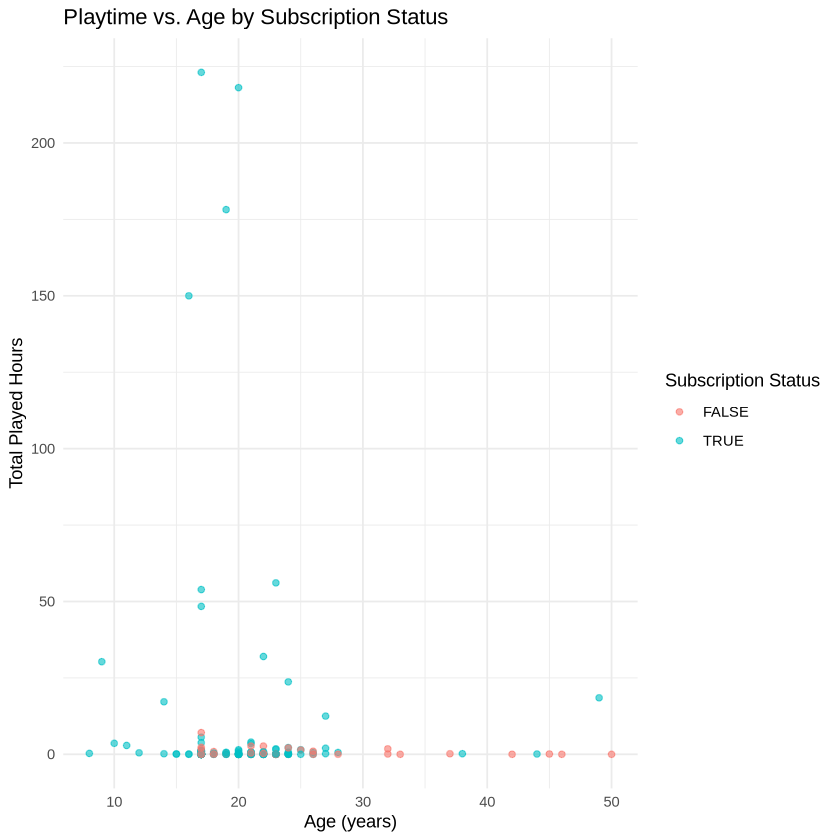

In [6]:
#Visualization of data: Scatter Plot of Playtime vs. Age (Colored by Subscription Status)
ggplot(clean_player, aes(x = Age, y = played_hours, color = as.factor(subscribe))) +
  geom_point(alpha = 0.6) +
  labs(
    title = "Playtime vs. Age by Subscription Status",
    x = "Age (years)",
    y = "Total Played Hours",
    color = "Subscription Status"
  ) +
  theme_minimal()

Before classification, we must determine the balance of subscriptions status to later determine whether our algorithm is better at predicting than random guessing. 

In [7]:
#balance of subscription status
table(clean_player$subscribe)


FALSE  TRUE 
   52   142 

We can tell that there is an obvious imbalance between the number of false and trues. This means that we need to calculate the random accuracy using the accuracy formula. 

In [8]:
# Given class counts
true_count <- 142
false_count <- 52
total_count <- true_count + false_count

# Calculate probabilities
p_true <- true_count / total_count
p_false <- false_count / total_count

# Random guessing accuracy formula
random_accuracy <- (p_true^2) + (p_false^2)

random_accuracy

[1] 0.6076097

In [9]:
set.seed(2025) 
player_split <- initial_split(clean_player, prop = 0.8, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

In [10]:
spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [11]:
recipe <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [12]:
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

In [13]:
player_fold <- vfold_cv(player_train, v = 5, strata = subscribe)

In [14]:
knn_results <- workflow() |>
  add_recipe(recipe) |>
  add_model(spec) |>
  tune_grid(resamples = player_fold, grid = k_vals) |>
  collect_metrics()

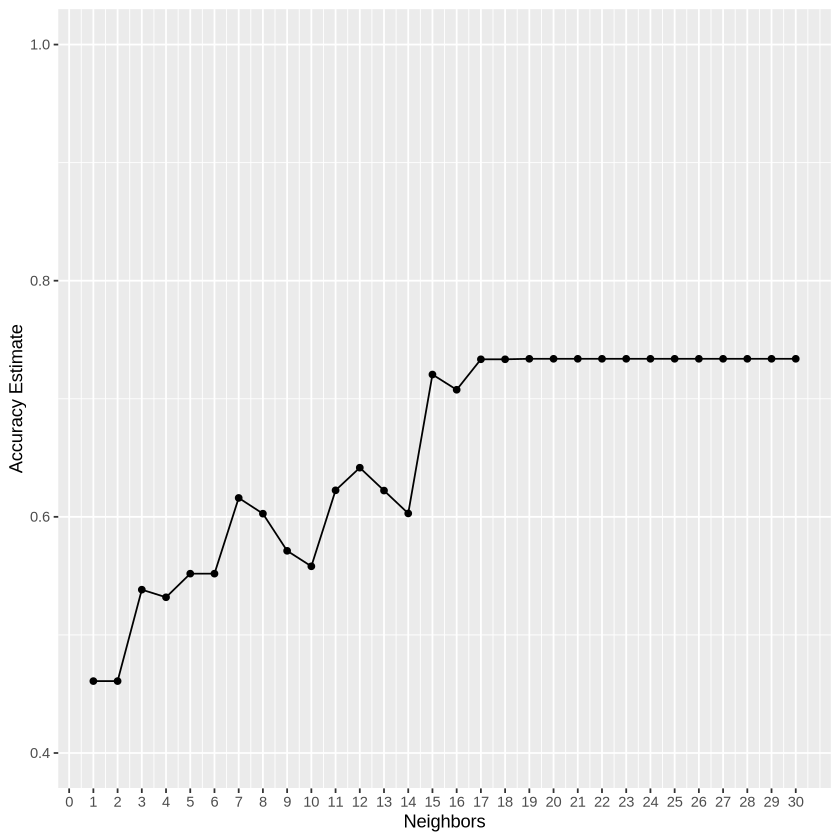

In [15]:
#accuracies and visualizing best k value
accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 30, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k

In [16]:
#From the graph, the best k value should be >17. This code determines the best k value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 19

From the graph and code we can tell that 19 neighbors provides the best accuracy estimation. 

In [17]:
#resampling
resample_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")
resample_tune

recipe2 <- recipe(subscribe ~ ., data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())
recipe2



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k
  weight_func = rectangular

Computational engine: kknn 




── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [18]:
resample_fit <- workflow() |>
  add_recipe(recipe2) |>
  add_model(resample_tune) |>
  fit(data = player_train)
resample_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2662338
Best kernel: rectangular
Best k: 19

In [19]:
#metrics 
player_predict <- predict(resample_fit, player_test) |>
  bind_cols(player_test)

player_predict |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


**Conclusion**

Accuracy (0.725 or 72.5%)
This means the model correctly classifies 72.5% of the instances. Given that random guessing accuracy is ~61%, we can say that this model is better at predicting a person's subscription status based on age and total played hours. 

# Results 
(Results)

# Discussion
(Discussion)

# References